In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class NaiveBayesClassifier:
    def __init__(self):
        self.probabilities_vector = pd.Series(dtype=np.float64)
        self.probabilities_table = None

    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        data = pd.DataFrame()
        data_length = len(X)
        for category in y.unique():
            temp_data = pd.DataFrame({'answer': [], 'variable': [], 'value': [], 'probability': []})

            filter_vector = y == category
            self.probabilities_vector[category] = np.sum(filter_vector) / data_length
            filtered_length = sum(filter_vector)
            for variable in X.columns:
                for value in X[variable].unique():
                    probability = len(X[filter_vector & (X[variable] == value)]) / filtered_length
                    if probability == 0:
                        probability = 1 / (len(X[variable].unique()) + filtered_length)
                    temp_data = pd.concat([temp_data, pd.DataFrame({
                            'answer': [category],
                            'variable': [variable],
                            'value': [value],
                            'probability': [probability]
                        })])

            data = pd.concat([data, temp_data])
        self.probabilities_table = data.pivot_table(columns='answer', index=['variable', 'value'], values='probability')

    def predict(self, X: pd.DataFrame) -> pd.Series:
        result = []
        for _, row in X.iterrows():
            scores = {k: v for k, v in self.probabilities_vector.items()}
            for column, value in row.items():
                for category in scores.keys():
                    scores[category] *= self.probabilities_table.loc[(column, value), category]
            result.append(sorted(scores.items(), key=lambda x: x[1], reverse=True)[0][0])
        return pd.Series(result)

In [3]:
train_set = pd.read_csv('data/bayes_trainingset.csv', header=None)
train_set.columns = ['outlook', 'windy', 'temperature', 'humidity', 'play']

In [4]:
model = NaiveBayesClassifier()
model.fit(train_set.iloc[:, :-1], train_set.iloc[:, -1])

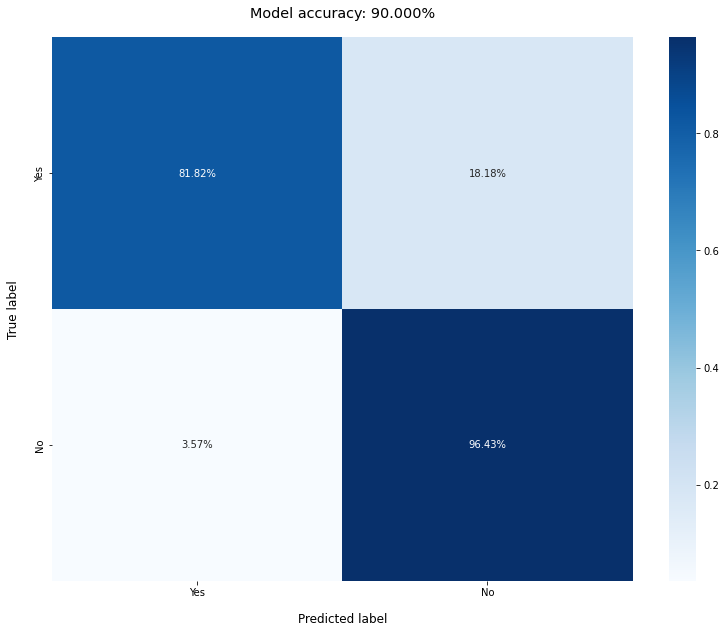

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

y_true = train_set.play
y_predicted = model.predict(train_set.iloc[:, :-1])

cm = confusion_matrix(y_true, y_predicted, normalize='true')
acc = accuracy_score(y_true, y_predicted)

cmdf = pd.DataFrame(cm)
cmdf.columns = cmdf.index = ["Yes", "No"]


fig, ax = plt.subplots()
fig.set_size_inches(13, 10)
sns.heatmap(cmdf, annot=True, fmt='.2%', cmap='Blues', ax=ax)
plt.title(f'Model accuracy: {acc:.3%}', fontsize='x-large', y=1.025)
plt.xlabel('Predicted label', fontsize='large', labelpad=15)
plt.ylabel('True label', fontsize='large', labelpad=15)
plt.show()

In [6]:
cat_data = train_set.copy(deep=True)
for col in cat_data.columns:
    cat_data[col] = cat_data[col].astype('category')
    series = cat_data[col]
    mappings = {k: v for k, v in zip(series.cat.categories, series.cat.codes)}
    cat_data[col] = cat_data[col].map(lambda x: mappings[x])

cat_data = cat_data.astype(int)

In [7]:
from sklearn.naive_bayes import BernoulliNB as NB
model = NB()
model.fit(cat_data.loc[:, 'outlook':], cat_data['play'])
sum(model.predict(cat_data.loc[:, 'outlook':]) == cat_data['play'])

50